In this project we take data of Airbnb listings in the US and try to predict the price of stay in that listing.
The source of the dataset:
https://www.kaggle.com/stevezhenghp/airbnb-price-prediction#train.csv

The data includes 74411 listings and 29 columns - including log_price, what we are trying to predict.

There was no information about this data so we assume that since all the listings are in the US, the price (or log_price) that we are trying to predict is the general pricing per 1 night stay of the listing, in USD.


## Importing necessary libraries and packages

In [742]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import pickle
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score

In [500]:
warnings.filterwarnings('ignore')

## Reading the Data

In [501]:
df=pd.read_csv('/content/drive/MyDrive/PROJECTS DS/AIRBNB/train.csv')

### Data Exploration

In [502]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [503]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [504]:
df.duplicated().sum()

0

In [505]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,74111.0,1.126662e+07,6.081735e+06,344.000000,6.261964e+06,1.225415e+07,1.640226e+07,2.123090e+07
log_price,74111.0,4.782069e+00,7.173938e-01,0.000000,4.317488e+00,4.709530e+00,5.220356e+00,7.600402e+00
accommodates,74111.0,3.155146e+00,2.153589e+00,1.000000,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,73911.0,1.235263e+00,5.820441e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
latitude,74111.0,3.844596e+01,3.080167e+00,33.338905,3.412791e+01,4.066214e+01,4.074610e+01,4.239044e+01
longitude,74111.0,-9.239753e+01,2.170532e+01,-122.511500,-1.183424e+02,-7.699696e+01,-7.395466e+01,-7.098505e+01
number_of_reviews,74111.0,2.090057e+01,3.782864e+01,0.000000,1.000000e+00,6.000000e+00,2.300000e+01,6.050000e+02
review_scores_rating,57389.0,9.406736e+01,7.836556e+00,20.000000,9.200000e+01,9.600000e+01,1.000000e+02,1.000000e+02
bedrooms,74020.0,1.265793e+00,8.521435e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+01
beds,73980.0,1.710868e+00,1.254142e+00,0.000000,1.000000e+00,1.000000e+00,2.000000e+00,1.800000e+01


In [506]:
df.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

### Null Values check

In [507]:
df.isna().sum()[df.isna().sum()>0]

bathrooms                   200
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
last_review               15827
neighbourhood              6872
review_scores_rating      16722
thumbnail_url              8216
zipcode                     966
bedrooms                     91
beds                        131
dtype: int64

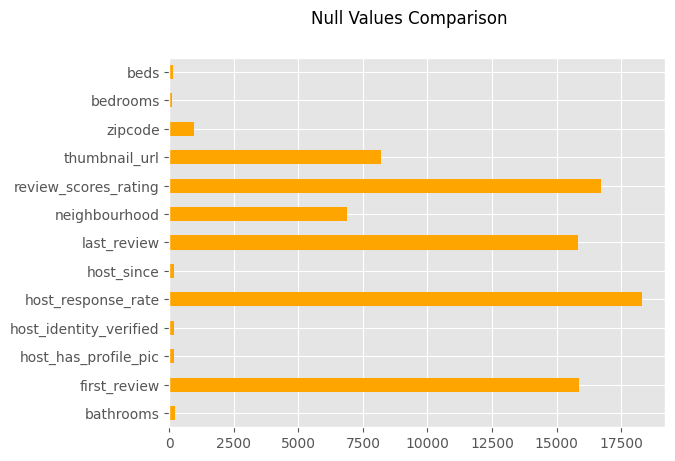

In [508]:
plt.style.use('ggplot')
df.isna().sum()[df.isna().sum()>0].plot.barh(color='orange')
plt.suptitle('Null Values Comparison')
plt.show()

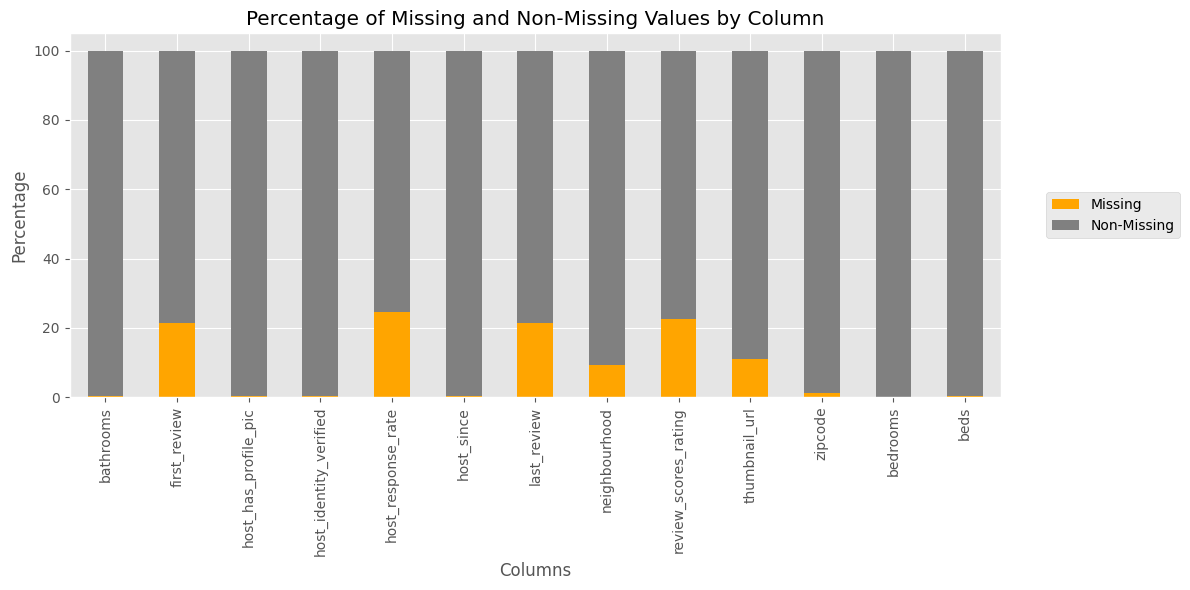

In [509]:
missing_percentage = df.isna().mean()[df.isna().mean()>0] * 100

non_missing_percentage = 100 - missing_percentage
percentages = pd.DataFrame({'Missing': missing_percentage, 'Non-Missing': non_missing_percentage})

ax = percentages.plot(kind='bar', stacked=True, color=['orange', 'grey'], figsize=(12, 6))

plt.title('Percentage of Missing and Non-Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage')

plt.legend(loc='center right',bbox_to_anchor=(1.2,0.5))

plt.tight_layout()
plt.show()

neighbourhood vs price
amenities vs price
zipcode vs price

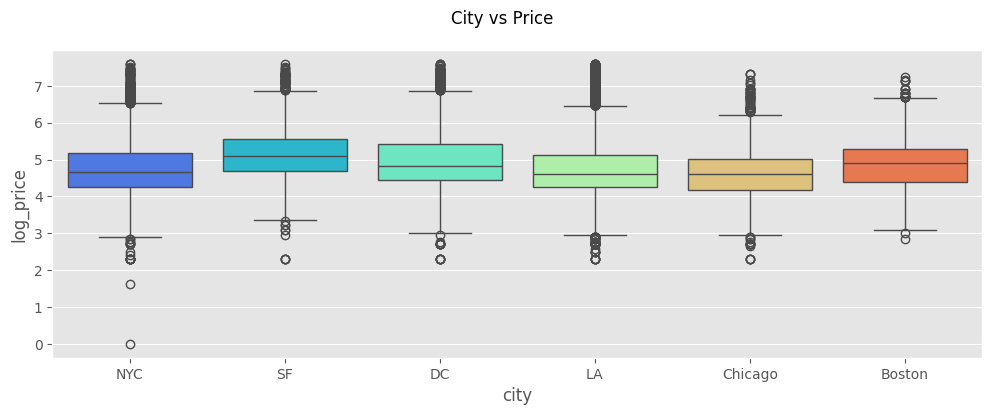

In [510]:
plt.figure(figsize=(12,4))

sns.boxplot(data=df,y='log_price',x='city',palette='rainbow')
plt.suptitle('City vs Price')
plt.savefig('City vs Price Distribution.jpeg')
plt.show()

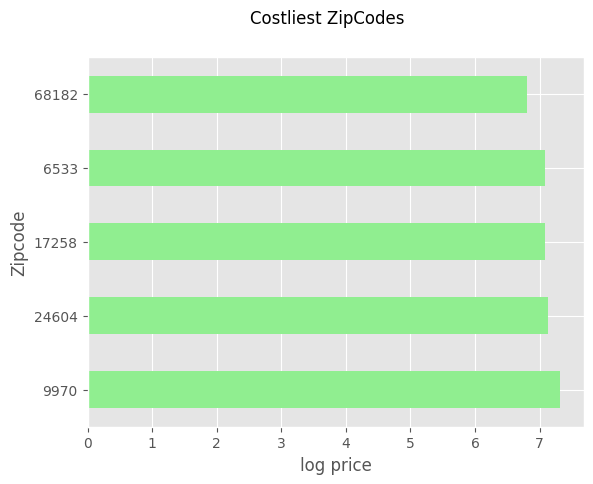

In [511]:
df.groupby('zipcode')['log_price'].transform(lambda x:np.mean(x)).sort_values(ascending=False).head().plot.barh(color='lightgreen')
plt.suptitle('Costliest ZipCodes')

plt.xlabel('log price')
plt.ylabel('Zipcode')

plt.savefig('Top 5 Costliest ZipCodes.jpeg')
plt.show()

### Data Preprocessing

Removing irrelevent and descriptive elements.

In [512]:
df.drop(['id','thumbnail_url','description','name','last_review','first_review'],axis=1,inplace=True)

In [513]:
na_fill=df.isna().sum()[(df.isna().sum()>0) &(df.isna().sum()<500)].keys()
na_fill

Index(['bathrooms', 'host_has_profile_pic', 'host_identity_verified',
       'host_since', 'bedrooms', 'beds'],
      dtype='object')

In [514]:
for i in na_fill:
  df[i]=df[i].fillna(df[i].mode()[0])



In [515]:
df.isna().sum()

log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                     0
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
host_has_profile_pic          0
host_identity_verified        0
host_response_rate        18299
host_since                    0
instant_bookable              0
latitude                      0
longitude                     0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
zipcode                     966
bedrooms                      0
beds                          0
dtype: int64

In [516]:
df['zipcode'].unique()

array(['11201', '10019', '10027', '94117.0', '20009', '94131', '90292',
       '90015', '94121', '91748', '10009.0', '90254', '90277', '90804',
       '60622', '02127', '10002', '11226.0', '91401', '11212.0',
       '11411.0', nan, '11374', '90028', '10016', '11225', '90036',
       '90291', '90046', '90026', '11212', '94118', '11211.0', '10003.0',
       '60605', '90068', '90057', '10021', '20037', '11237', '11233',
       '60608', '10001.0', '94127', '91403', '11249.0', '10037', '10011',
       '10011.0', '10032', '91106', '94107', '20018', '90027', '91601',
       '20001', '10022', '91201', '11226', '90013', '11217', '91016',
       '10031', '10014', '11101', '94110', '94134', '91501', '10029.0',
       '90230', '90039', '11221', '20019', '60647', '20020', '10025',
       '10013', '10040', '91604', '94117', '10039', '10038', '60614',
       '10003', '20002', '11219', '11222', '90042', '94114', '20008',
       '11238', '20007', '11206', '91208', '11223', '02130', '02114',
       '941

In [518]:
def zip_clean(zip):
  zip=str(zip)
  match = re.search(r'\d{5}', zip)
  if match:
      return int(match.group())
  else:
      return None

In [519]:
df['zipcode']=df['zipcode'].apply(zip_clean)

In [520]:
df['zipcode']=df['zipcode'].fillna(df.groupby('city')['zipcode'].transform(lambda x: x.mode()[0]))


In [522]:
df.isna().sum()

log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                     0
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
host_has_profile_pic          0
host_identity_verified        0
host_response_rate        18299
host_since                    0
instant_bookable              0
latitude                      0
longitude                     0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
zipcode                       0
bedrooms                      0
beds                          0
dtype: int64

Dropping the remaining null values as filling a lot of null values may cause the performance to drop.

In [523]:
df.dropna(inplace=True)

In [524]:
df.head(2)

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,host_since,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
1,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,2017-06-19,t,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019.0,3.0,3.0
2,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,2016-10-25,t,40.808110,-73.943756,Harlem,10,92.0,10027.0,1.0,3.0


In [525]:
df.reset_index(inplace=True,drop=True)
df.head(2)

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,host_since,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,2017-06-19,t,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019.0,3.0,3.0
1,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,2016-10-25,t,40.808110,-73.943756,Harlem,10,92.0,10027.0,1.0,3.0


In [526]:
df['host_response_rate'].unique()

array(['100%', '71%', '68%', '67%', '90%', '86%', '92%', '82%', '80%',
       '89%', '93%', '99%', '50%', '88%', '96%', '70%', '91%', '25%',
       '83%', '95%', '98%', '62%', '29%', '81%', '63%', '60%', '79%',
       '78%', '75%', '65%', '94%', '97%', '87%', '40%', '33%', '58%',
       '0%', '76%', '30%', '64%', '17%', '20%', '77%', '53%', '54%',
       '73%', '41%', '57%', '85%', '56%', '42%', '44%', '14%', '10%',
       '72%', '36%', '84%', '55%', '43%', '38%', '74%', '39%', '46%',
       '26%', '61%', '59%', '52%', '22%', '15%', '69%', '27%', '11%',
       '35%', '31%', '21%', '47%', '66%'], dtype=object)

In [527]:
df['host_response_rate']=df['host_response_rate'].str.replace('%','').astype(float)

Changing the datatype of host since column to extract the year

In [528]:
df['host_since']=pd.to_datetime(df['host_since']).apply(lambda x:x.year)

In [529]:
df['host_since'].unique()

array([2017, 2016, 2015, 2013, 2012, 2014, 2011, 2010, 2009, 2008])

In [530]:
df.dtypes

log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate        float64
host_since                  int64
instant_bookable           object
latitude                  float64
longitude                 float64
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
zipcode                   float64
bedrooms                  float64
beds                      float64
dtype: object

In [531]:
df['property_type'].unique()

array(['Apartment', 'Condominium', 'House', 'Townhouse', 'Loft', 'Hostel',
       'Guest suite', 'Bungalow', 'Guesthouse', 'Dorm', 'Other',
       'Bed & Breakfast', 'Boutique hotel', 'Villa', 'Timeshare',
       'In-law', 'Boat', 'Serviced apartment', 'Camper/RV', 'Castle',
       'Cabin', 'Treehouse', 'Tipi', 'Hut', 'Vacation home', 'Tent',
       'Chalet', 'Yurt', 'Earth House', 'Train', 'Cave'], dtype=object)

In [532]:
df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [533]:
df['bathrooms'].unique()

array([1. , 1.5, 2. , 3. , 2.5, 0. , 4. , 3.5, 0.5, 5.5, 4.5, 5. , 6.5,
       8. , 6. , 7.5, 7. ])

In [534]:
df['bathrooms']=df['bathrooms'].apply(int)

Exploring the amenities column

In [535]:
df['amenities'][0]

'{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"translation missing: en.hosting_amenity_50"}'

In [536]:
df['amenities'][0].replace('{','').replace('}','').replace('"','').strip().split(',')

['Wireless Internet',
 'Air conditioning',
 'Kitchen',
 'Heating',
 'Family/kid friendly',
 'Washer',
 'Dryer',
 'Smoke detector',
 'Fire extinguisher',
 'Essentials',
 'Shampoo',
 'Hangers',
 'Hair dryer',
 'Iron',
 'translation missing: en.hosting_amenity_50']

In [537]:
all_aminities=[]
for i in df['amenities']:
  k=i.replace('{','').replace('}','').replace('"','').split(',')
  for j in k:
    all_aminities.append(j)


In [538]:
len(set(all_aminities))

131

In [539]:
from collections import Counter

In [540]:
feature_counts = Counter(all_aminities)

In [541]:
amenity_df=pd.DataFrame(list(feature_counts.items()),columns=['amenity','count'])

In [542]:
top_8_amenity=amenity_df.sort_values(by='count',ascending=False).head(8)
top_8_amenity

,amenity,count
0,Wireless Internet,42491
3,Heating,40744
2,Kitchen,39582
9,Essentials,38918
7,Smoke detector,37483
1,Air conditioning,33117
11,Hangers,32274
15,TV,31567


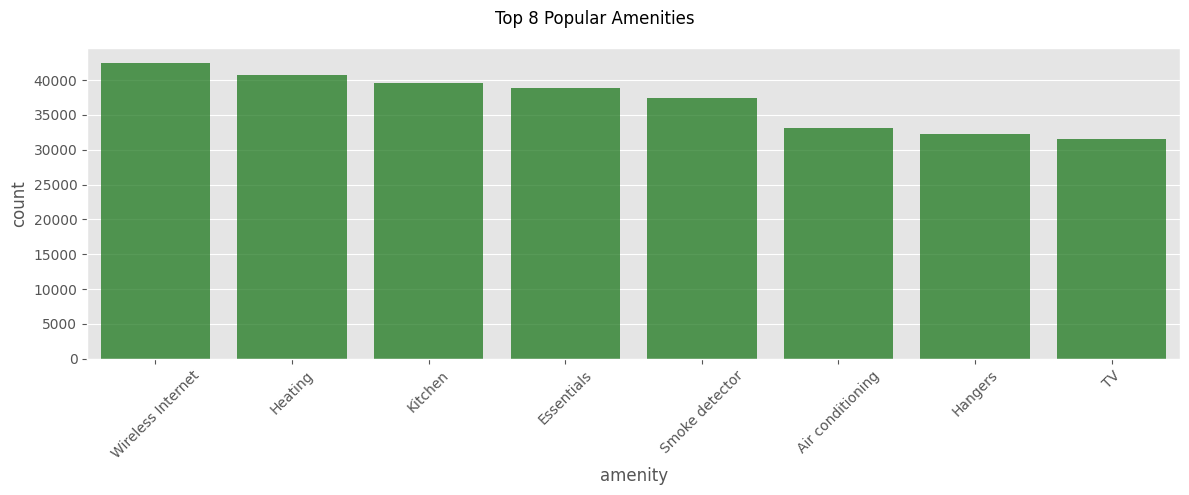

In [543]:
plt.figure(figsize=(12,5))
sns.barplot(data=top_8_amenity,x='amenity',y='count',color='green',alpha=0.7)
plt.xticks(rotation=45)
plt.suptitle('Top 8 Popular Amenities')
plt.tight_layout()

plt.savefig('Top 8 Popular Amenities.jpeg')
plt.show()

passing the top 8 aminities as features.

In [544]:
top_8_amenities=top_8_amenity['amenity'].values
print(top_8_amenities)

['Wireless Internet' 'Heating' 'Kitchen' 'Essentials' 'Smoke detector'
 'Air conditioning' 'Hangers' 'TV']


In [545]:
def cleaned_am(am):
  k=am.replace('{','').replace('}','').replace('"','').split(',')
  return k


In [546]:
df['amenities']=df['amenities'].apply(cleaned_am)

Adding a Feature to show the total amenities for each row

In [547]:
df['total amenities']=df['amenities'].apply(len)

In [548]:
df['total amenities'].unique()

array([15, 19, 12, 10, 26, 21, 22, 25, 18, 24, 11, 29, 44, 27, 14, 17, 28,
       20, 16, 23,  8, 13, 43,  5,  7,  9, 32,  6, 41, 30,  3, 42, 33, 31,
        1, 37, 38,  2,  4, 39, 49, 36, 34, 40, 35, 57, 48, 45, 47, 51, 55,
       53, 46, 58, 62, 50, 70, 61, 52, 68, 54, 59, 60, 56, 63, 64, 72, 71,
       77, 69])

In [549]:
for feature in top_8_amenities:
    df[f'{feature}'] = df['amenities'].apply(lambda x: feature in x)

In [550]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43295 entries, 0 to 43294
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               43295 non-null  float64
 1   property_type           43295 non-null  object 
 2   room_type               43295 non-null  object 
 3   amenities               43295 non-null  object 
 4   accommodates            43295 non-null  int64  
 5   bathrooms               43295 non-null  int64  
 6   bed_type                43295 non-null  object 
 7   cancellation_policy     43295 non-null  object 
 8   cleaning_fee            43295 non-null  bool   
 9   city                    43295 non-null  object 
 10  host_has_profile_pic    43295 non-null  object 
 11  host_identity_verified  43295 non-null  object 
 12  host_response_rate      43295 non-null  float64
 13  host_since              43295 non-null  int64  
 14  instant_bookable        43295 non-null

In [551]:
df.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,beds,total amenities,Wireless Internet,Heating,Kitchen,Essentials,Smoke detector,Air conditioning,Hangers,TV
0,5.129899,Apartment,Entire home/apt,"[Wireless Internet, Air conditioning, Kitchen,...",7,1,Real Bed,strict,True,NYC,...,3.0,15,True,True,True,True,True,True,True,False
1,4.976734,Apartment,Entire home/apt,"[TV, Cable TV, Wireless Internet, Air conditio...",5,1,Real Bed,moderate,True,NYC,...,3.0,19,True,True,True,True,True,True,True,True
2,4.744932,Apartment,Entire home/apt,"[TV, Internet, Wireless Internet, Air conditio...",2,1,Real Bed,moderate,True,DC,...,1.0,12,True,True,True,True,True,True,False,True
3,4.442651,Apartment,Private room,"[TV, Wireless Internet, Heating, Smoke detecto...",2,1,Real Bed,strict,True,SF,...,1.0,10,True,True,False,True,True,False,True,True
4,4.787492,Condominium,Entire home/apt,"[TV, Cable TV, Wireless Internet, Wheelchair a...",2,1,Real Bed,moderate,True,LA,...,1.0,26,True,True,True,True,True,False,True,True


In [552]:
df.drop('amenities',axis=1,inplace=True)

### Label Encoding the boolian and object data types

In [553]:
bool_and_object_cols = df.select_dtypes(include=['bool','object']).columns
bool_and_object_cols

Index(['property_type', 'room_type', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'host_has_profile_pic',
       'host_identity_verified', 'instant_bookable', 'neighbourhood',
       'Wireless Internet', 'Heating', 'Kitchen', 'Essentials',
       'Smoke detector', 'Air conditioning', 'Hangers', 'TV'],
      dtype='object')

In [554]:
from sklearn.preprocessing import LabelEncoder

Label Encoding and also mapping the encoded values to later use in streamlit.

In [555]:
encoders = {}
mappings = {}
classes={}

for col in bool_and_object_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
    classes[col]=le.classes_
    mappings[col] = {label: id for id, label in enumerate(le.classes_)}


for col, mapping in mappings.items():
    print(f"{col}: {mapping}")

property_type: {'Apartment': 0, 'Bed & Breakfast': 1, 'Boat': 2, 'Boutique hotel': 3, 'Bungalow': 4, 'Cabin': 5, 'Camper/RV': 6, 'Castle': 7, 'Cave': 8, 'Chalet': 9, 'Condominium': 10, 'Dorm': 11, 'Earth House': 12, 'Guest suite': 13, 'Guesthouse': 14, 'Hostel': 15, 'House': 16, 'Hut': 17, 'In-law': 18, 'Loft': 19, 'Other': 20, 'Serviced apartment': 21, 'Tent': 22, 'Timeshare': 23, 'Tipi': 24, 'Townhouse': 25, 'Train': 26, 'Treehouse': 27, 'Vacation home': 28, 'Villa': 29, 'Yurt': 30}
room_type: {'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}
bed_type: {'Airbed': 0, 'Couch': 1, 'Futon': 2, 'Pull-out Sofa': 3, 'Real Bed': 4}
cancellation_policy: {'flexible': 0, 'moderate': 1, 'strict': 2, 'super_strict_30': 3, 'super_strict_60': 4}
cleaning_fee: {False: 0, True: 1}
city: {'Boston': 0, 'Chicago': 1, 'DC': 2, 'LA': 3, 'NYC': 4, 'SF': 5}
host_has_profile_pic: {'f': 0, 't': 1}
host_identity_verified: {'f': 0, 't': 1}
instant_bookable: {'f': 0, 't': 1}
neighbourhood: {'16th Stree

In [556]:
print(mappings['property_type'])

{'Apartment': 0, 'Bed & Breakfast': 1, 'Boat': 2, 'Boutique hotel': 3, 'Bungalow': 4, 'Cabin': 5, 'Camper/RV': 6, 'Castle': 7, 'Cave': 8, 'Chalet': 9, 'Condominium': 10, 'Dorm': 11, 'Earth House': 12, 'Guest suite': 13, 'Guesthouse': 14, 'Hostel': 15, 'House': 16, 'Hut': 17, 'In-law': 18, 'Loft': 19, 'Other': 20, 'Serviced apartment': 21, 'Tent': 22, 'Timeshare': 23, 'Tipi': 24, 'Townhouse': 25, 'Train': 26, 'Treehouse': 27, 'Vacation home': 28, 'Villa': 29, 'Yurt': 30}


In [557]:
df.dtypes

log_price                 float64
property_type               int64
room_type                   int64
accommodates                int64
bathrooms                   int64
bed_type                    int64
cancellation_policy         int64
cleaning_fee                int64
city                        int64
host_has_profile_pic        int64
host_identity_verified      int64
host_response_rate        float64
host_since                  int64
instant_bookable            int64
latitude                  float64
longitude                 float64
neighbourhood               int64
number_of_reviews           int64
review_scores_rating      float64
zipcode                   float64
bedrooms                  float64
beds                      float64
total amenities             int64
Wireless Internet           int64
Heating                     int64
Kitchen                     int64
Essentials                  int64
Smoke detector              int64
Air conditioning            int64
Hangers       

Checking the correlation with the target

In [558]:
df.corr()['log_price'].sort_values(ascending=False)

log_price                 1.000000
accommodates              0.594425
bedrooms                  0.502222
beds                      0.462160
bathrooms                 0.336784
TV                        0.272948
total amenities           0.226060
cancellation_policy       0.189390
cleaning_fee              0.170622
Kitchen                   0.126888
bed_type                  0.113759
Heating                   0.095970
neighbourhood             0.091204
Hangers                   0.085088
review_scores_rating      0.076137
zipcode                   0.061762
Smoke detector            0.057646
Essentials                0.056843
Wireless Internet         0.049092
city                      0.047510
host_identity_verified    0.045469
Air conditioning          0.037875
property_type             0.025419
host_response_rate        0.002757
host_has_profile_pic     -0.013996
number_of_reviews        -0.021697
latitude                 -0.033373
instant_bookable         -0.047840
host_since          

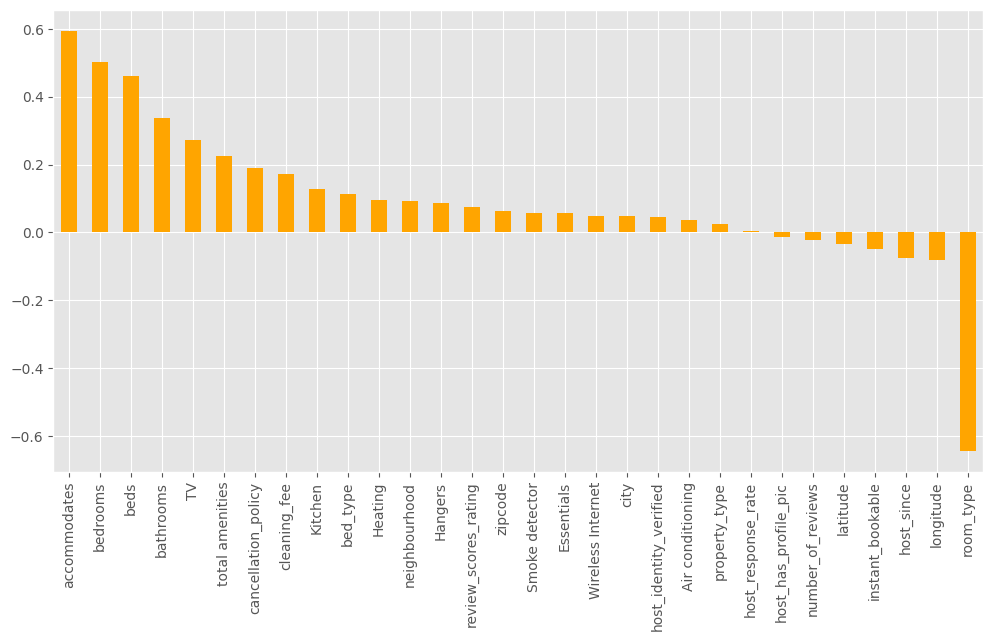

In [559]:
plt.figure(figsize=(12,6))
df.corr()['log_price'].sort_values(ascending=False)[1:].plot(kind='bar',color='orange')
plt.show()

### Initial training without feature selection

In [561]:
X=df.drop('log_price',axis=1)
y=df['log_price']

### Scaling and splitting

In [677]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)

In [707]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=18)

In [708]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBRegressor' : XGBRegressor()
}

In [709]:
r2_list=[]
mse_list=[]
kf_list=[]
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    mse = mean_squared_error(y_test, y_pred)
    kf = cross_val_score(estimator=model, X=X_train, y=y_train, cv=3)
    r2_list.append(r2)
    mse_list.append(mse)
    kf_list.append(kf.mean())

In [710]:
score_comparison = pd.DataFrame({'Model': models.keys(), 'R2-Score': r2_list, 'MSE':mse_list, 'K-Fold': kf_list})
score_comparison

,Model,R2-Score,MSE,K-Fold
0,Linear Regression,0.629681,0.164000,0.628531
1,Ridge Regression,0.629556,0.164055,0.628499
2,Random Forest,0.764298,0.104383,0.752205
3,Gradient Boosting,0.733754,0.117910,0.730575
4,XGBRegressor,0.771552,0.101170,0.759900


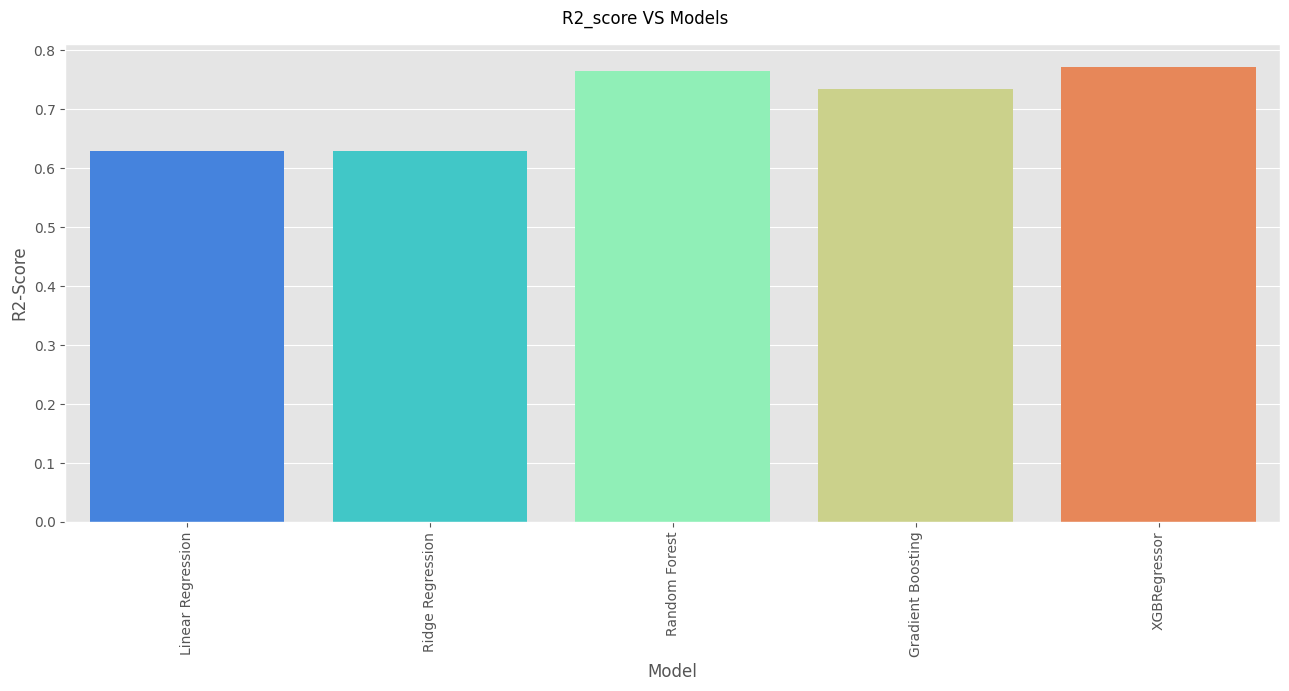

In [748]:
plt.figure(figsize=(13,7))
sns.barplot(data=score_comparison,x='Model',y='R2-Score',palette='rainbow')
plt.suptitle('R2_score VS Models')
plt.xticks(ticks=range(0,5),labels=models.keys(),rotation=90)
plt.tight_layout()
plt.savefig('R2_score VS Models.jpeg')
plt.show()


Since XGBRegressor performed the best, using XGBRegressor as the model to predict the prices.

### Hyper Parameter Tuning

In [712]:
from sklearn.model_selection import  GridSearchCV
xgb=XGBRegressor()

In [713]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

In [714]:
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

In [715]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             verbose=2)

In [716]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


In [717]:
best_model = grid_search.best_estimator_

In [718]:
y_pred = best_model.predict(X_test)

In [719]:
r2=r2_score(y_test,y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R2: ',r2)
print('MSE:',mse)

R2:  0.7778353095021389
MSE: 0.09838795739688554


Hyper Parameter Tuning only slightly improved the performance of the model.

### Feature Selection

In [720]:
from sklearn.feature_selection import RFE


In [721]:
rfe = RFE(best_model, n_features_to_select=10)

In [722]:
rfe = rfe.fit(X, y)

In [723]:
rfe.get_feature_names_out()

array(['room_type', 'accommodates', 'bathrooms', 'city', 'latitude',
       'longitude', 'review_scores_rating', 'zipcode', 'bedrooms', 'TV'],
      dtype=object)

In [724]:
X_selected = X[rfe.get_feature_names_out()]

In [725]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=18)

In [726]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
r2=r2_score(y_test,y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R2: ',r2)
print('MSE:',mse)


R2:  0.7633358699554296
MSE: 0.10611916147427924


Feature selection did not improve the performance of the model

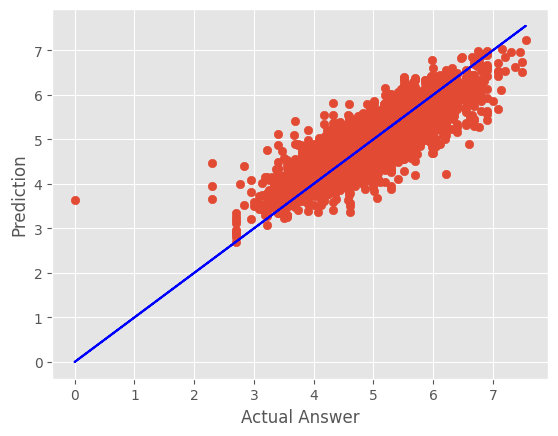

In [727]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual Answer')
plt.ylabel('Prediction')
plt.plot(y_test,y_test,color='blue')
plt.show()

Creating a Prediction Function

In [728]:
def prediction(input):
  result=best_model.predict([input])
  return result


In [737]:
y[3]

4.442651256490317

In [738]:
X_selected.iloc[3]

room_type                   1.000000
accommodates                2.000000
bathrooms                   1.000000
city                        5.000000
latitude                   37.753164
longitude                -122.429526
review_scores_rating      100.000000
zipcode                 94131.000000
bedrooms                    1.000000
TV                          1.000000
Name: 3, dtype: float64

In [735]:
example_pred=prediction(X_selected.iloc[3].values)

In [740]:
print('Predicted:',example_pred[0],'\nActual:',y[3])

Predicted: 4.900045 
Actual: 4.442651256490317


In [749]:
import pickle
pickle.dump(best_model,open('airbnb.sav','wb'))